# Regularized Least Squares

Regularization introduces to an optimization problem prior information
or assumptions about properties of an optimal solution. A regularization
parameter governs the tradeoff between the fidelity to the unmodified
problem and the desired solution properties.

## Slides

[View slides in full screen](../slides/regularized-least-squares.qmd) \|
[PDF](../slides/regularized-least-squares.pdf)

> **Packages used in this notebook**
>
> ``` julia
> using Random; Random.seed!(1234)
> using Convex, ECOS, LinearAlgebra, Plots
> ```

## The Pareto frontier

The standard [least-squares problem](../notes/least-squares.qmd) can be
interpreted as a method for recovering some underlying object (say, a
signal or image) encoded in the vector $x_0$ using noisy measurements of
the form <span id="eq-standard-ls">$$ 
   b := Ax_0 + \eta,
 \qquad(1)$$</span> where $\eta$ is random additive error in the
observations $b$ and the matrix $A$ describes the measurement process.
The least-squares problem $$
  \min_{x\in\Rn}\ \|Ax-b\|^2.
$$ seeks a solution $x$ under the implicit assumption that the noise
term $\eta$ is small.

But what if $x$ also needs to satisfy some other competing objective?
Suppose, for example, that we have also available other set of
measurements of $x_0$ of the form $d = Cx_0+w$, where $w$ is also random
error. The “best” choice for $x$ is not necessarily
<a href="#eq-standard-ls" class="quarto-xref">Equation 1</a>, and
instead we wish to choose $x$ to balance the two objective function
values <span id="eq-weighted-problem">$$
f_1(x)  \quad\text{and}\quad f_2(x).
 \qquad(2)$$</span>

Generally, we can make $f_1(x)$ or $f_2(x)$ small, but not both.
<a href="#fig-pareto-frontier" class="quarto-xref">Figure 1</a> sketches
the relationship between the pair $\xi(x):=\{f_1(x), f_2(x)\}$.

<figure id="fig-pareto-frontier">
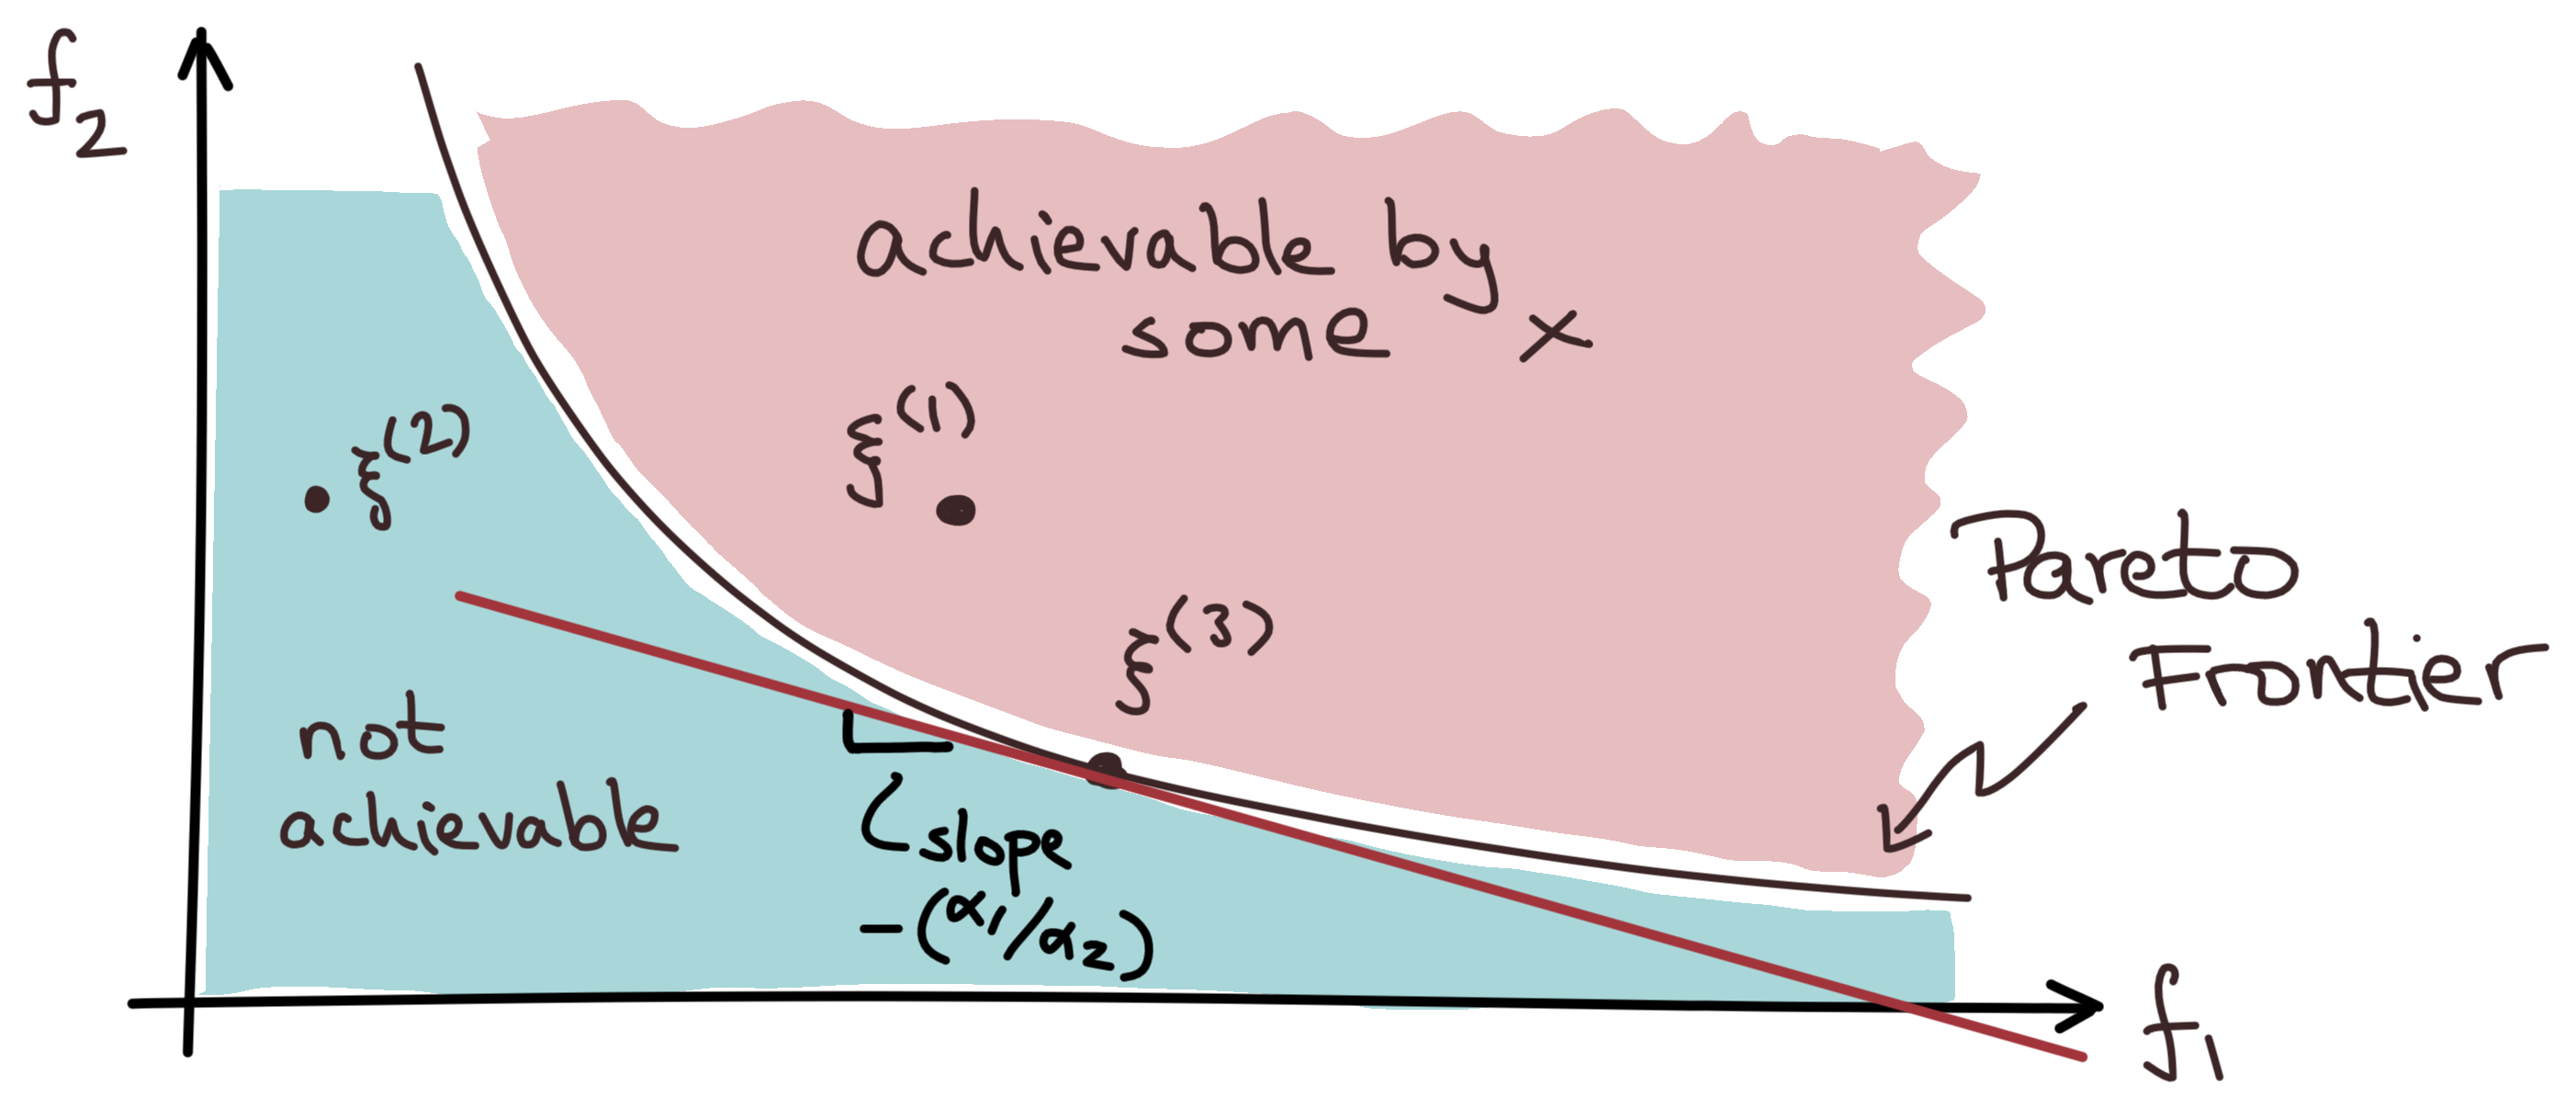
<figcaption>Figure 1: The Pareto frontier. The points <span
class="math inline"><em>ξ</em><sup>(<em>i</em>)</sup> := (<em>f</em><sub>1</sub>(<em>x</em><sup>(<em>i</em>)</sup>), <em>f</em><sub>2</sub>(<em>x</em><sup>(<em>i</em>)</sup>))</span>
correspond to a solution <span
class="math inline"><em>x</em><sup>(<em>i</em>)</sup></span> of the
weighted problem <a href="#eq-weighted-problem"
class="quarto-xref">Equation 2</a>. The area above the curve are
possibly realizable for some <span
class="math inline"><em>x</em></span>; the points below the curve are
not achievable by <em>any</em> <span
class="math inline"><em>x</em></span>.</figcaption>
</figure>

The objective pairs on the boundary of two regions is the [Pareto
frontier](https://en.wikipedia.org/wiki/Pareto_efficiency). We can
compute these Pareto optimal solutions $x$ by solving the optimization
problem

<span id="eq-regularized_LS_weights">$$ 
\min_x \{α₁f_1(x)+α_2 f_2(x)\,\},
 \qquad(3)$$</span>

where the pair of positive *penalty* parameters $(\alpha_1,\alpha_2)$
provides the relative weight between the objectives.

For fixed penalties $\alpha_1$ and $α_2$, the set

$$
\{\ (f_1(x),f_2(x)) \mid α_1f_1(x) + α_2 f_2(x) = \alpha,\ x \in \R^n\ \}
$$

forms the graph of a line with slope of $-(α_1/α_2)$. We may visualize
the optimization problem in
<a href="#eq-regularized_LS_weights" class="quarto-xref">Equation 3</a>
as the problem of finding the smallest value $\alpha$ such that the line
is tangent to the Pareto frontier, as shown in
<a href="#fig-pareto-frontier" class="quarto-xref">Figure 1</a>.

<a href="#fig-nonconvex-pareto" class="quarto-xref">Figure 2</a> shows
an example of a nonconvex Pareto frontier. In this case, the Pareto
optimal solutions are not unique, and so the optimization problem
<a href="#eq-regularized_LS_weights" class="quarto-xref">Equation 3</a>
may have multiple solutions.

<figure id="fig-nonconvex-pareto">
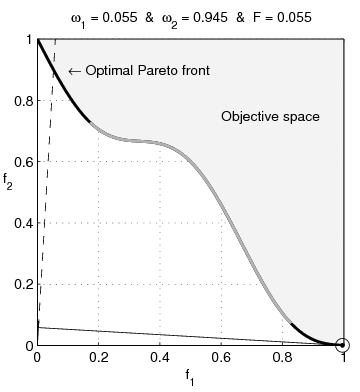
<figcaption>Figure 2: A nonconvex Pareto frontier <a
href="https://en.m.wikipedia.org/wiki/File:NonConvex.gif">(Wikipedia,
courtesy G. Jacquenot)</a>, <a
href="https://creativecommons.org/licenses/by-sa/3.0/deed.en">CC-BY-SA3.0</a></figcaption>
</figure>

> **Note**
>
> <a href="#eq-regularized_LS_weights" class="quarto-xref">Equation 3</a>
> is formulated using two penalty parameters, one for each objective. In
> general, we may have more than two objectives, and so we would need to
> introduce a penalty parameter for each objective. But in the
> particular case where we have only two objectives, we can equivalently
> formulate the problem using a single penalty parameter $\lambda$:
>
> <span id="eq-lagrangian">$$
> \min_x \{f_1(x) + \lambda f_2(x)\,\},
>  \qquad(4)$$</span>
>
> with $\lambda=α_2/α_1$. This is possible because multiplying the
> objective function by a positive constant does not change the location
> of the Pareto frontier.

## Tikhonov regularization

A particularly common example of regularized least-squares is [Tikhonov
regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization),
which has the form

$$
\min_{x} \half\|Ax-b\|^2 + \lambda\half\|Dx\|^2.
$$

This objective can be expressed equivalently as

$$
\|Ax-b\|^2+\lambda\|Dx\|^2
 = \bigg\|\begin{bmatrix}A\\\sqrt{\lambda}D\end{bmatrix} x
   - \begin{bmatrix}b\\ 0\end{bmatrix}\bigg\|^2.
$$

If $D$ has full column rank, then the stacked matrix $$
\begin{bmatrix}A\\\sqrt{\lambda}D\end{bmatrix}
$$ necessarily also has full rank for any positive $\lambda$, which
implies that the regularized problem always has a well-defined unique
solution.

## Example: Signal denoising

Consider a noisy measurement

$$
b := x^\natural + \eta
$$

of a signal $x^\natural$, where the vector $\eta$ represents unknown
noise, say, due to measurement error. Here’s a simple 1-dimensional
noisy signal:

In [1]:
n = 300
t = LinRange(0, 4, n)
x = @. sin(t) + t*cos(t)^2
w = 0.1*randn(n)
b = x + w
plot(b, leg=:topleft, label="noisy signal")

The obvious least-squares problem

$$
\min_{x}\ \half\|x-b\|^2
$$

isn’t useful because the optimal solution is simply the noisy
measurements $b$, and so it doesn’t yield any new information. But
suppose we believe that the signal is “smooth” in the sense that the
consecutive elements of the vector
$$ x=(x_1,\ldots,x_i,x_{i+1},\ldots,x_n)$$ change relatively little,
i.e., the difference $|x_i-x_{i+1}|$ is small relative to $x$. In this
case, we might balance the least-squares fit against the smoothness of
the solution by instead solving the regularized least-squares problem

<span id="eq-regularized_LS_identity">$$
  \min_{x}\ \half\underbrace{\vphantom{\sum_{i=1}}\|x-b\|^2}_{f_1(x)} + λ\half \underbrace{\sum_{i=1}^{n-1}(x_i - x_{i+1})^2}_{f_2(x)}.
 \qquad(5)$$</span>

The role of the regularizer $f_2(x)$ is to promote smooth changes in the
elements of $x$.

### Matrix notation

We can alternatively write the above minimization program in matrix
notation. Define the $(n-1)$-by-$n$ finite difference matrix

$$
D = \begin{bmatrix}
      1 & -1 & \phantom+0 & \cdots & \cdots & \phantom+0\\
      0 & \phantom+1 & -1 & 0 & \cdots & \phantom+0\\
      \vdots & \ddots  & \ddots & \ddots &  & \vdots  \\
      \vdots & \cdots  & \phantom+0 & 1 & -1 & \phantom+0\\
      0 & \cdots &  & 0 & \phantom+1 & -1
       \end{bmatrix}
$$ which when applied to a vector $x$, yields a vector of the
differences:

$$
Dx = \begin{bmatrix}
       x_1 - x_2 \\ x_2 - x_3 \\ \vdots \\ x_{n-1} - x_n
     \end{bmatrix}.
$$

Then we can rephrase the regularization objective as
$$ f_2(x) = \sum_{i=1}^{n-1}(x_i - x_{i+1})^2 = \|Dx\|^2. $$ This allows
for a reformulation of the weighted leas squares objective into a
familiar least squares objective:

$$
  \|x-b\|^2+\lambda\|Dx\|^2
  = \bigg\|
      \underbrace{
         \begin{bmatrix}
             I\\\sqrt{\lambda}D
         \end{bmatrix}}_{\hat{A}}x
         - 
      \underbrace{
        \begin{bmatrix}b\\ 0\end{bmatrix}}_{\hat{b}}\bigg\|^2.
$$

So the solution to the weighted least squares minimization program
{#eq-regularized_LS_identity} satisfies the normal equation
$\hat{A}\T\hat{A}x = \hat{A}\T\hat{b}$, which simplifies to

$$
(I + \lambda D\T D)x = b.
$$

The following function generates the required finite-difference matrix
using a sparse matrix data structure, which is more efficient than a
dense matrix for large $n$ because it only stores the nonzero entries:

In [1]:
using SparseArrays: spdiagm
finiteDiff(n) = spdiagm(0 => ones(n), +1 => -ones(n-1))[1:n-1,:];

Here’s an example of a small finite-difference matrix:

In [1]:
finiteDiff(4)

3×4 SparseArrays.SparseMatrixCSC{Float64, Int64} with 6 stored entries:
 1.0  -1.0    ⋅     ⋅ 
  ⋅    1.0  -1.0    ⋅ 
  ⋅     ⋅    1.0  -1.0

The function below returns a
[generator](https://docs.julialang.org/en/v1/manual/arrays/#Generator-Expressions),
which produces $n$ logarithmically-spaced numbers in the interval
$[x_1,x_2]$:

In [1]:
LogRange(x1, x2, n) = (10^y for y in range(log10(x1), log10(x2), length=n));

Now solve the regularized least-squares problem for several values of
$\lambda\in[1,10^4]$:

In [1]:
D = finiteDiff(n)
b̂ = [b; zeros(n-1)]
p = plot(t, b, w=1, leg =:topleft, label="noisy data")
for λ in LogRange(1e0, 1e4, 10) 
    Â = [ I; √λ*D ]
    xLS = Â \ b̂
    plot!(p, t, xLS, w=2, label="regularized solution: λ = $(round(λ))")
end
display(p)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<path clip-path="url(#clip620)" d="M185.28 1834 Q181.669 1834 179.84 1837.57 Q178.034 1841.11 178.034 1848.24 Q178.034 1855.34 179.84 1858.91 Q181.669 1862.45 185.28 1862.45 Q188.914 1862.45 190.719 1858.91 Q192.548 1855.34 192.548 1848.24 Q192.548 1841.11 190.719 1837.57 Q188.914 1834 185.28 1834 M185.28 1830.3 Q191.09 1830.3 194.145 1834.9 Q197.224 1839.49 197.224 1848.24 Q197.224 1856.96 194.145 1861.57 Q191.09 1866.15 185.28 1866.15 Q179.469 1866.15 176.391 1861.57 Q173.335 1856.96 173.335 1848.24 Q173.335 1839.49 176.391 1834.9 Q179.469 1830.3 185.28 1830.3 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip620)" d="M1371.91 1861.55 L1388.23 1861.55 L1388.23 1865.48 L1366.29 1865.48 L1366.29 1861.55 Q1368.95 1858.79 1373.53 1854.16 Q1378.14 1849.51 1379.32 1848.17 Q1381.56 1845.65 1382.44 1843.91 Q1383.35 1842.15 1383.35 1840.46 Q1383.35 1837.71 1381.4 1835.97 Q1379.48 1834.23 1376.38 1834.23 Q1374.18 1834.23 1371.73 1835 Q1369.3 1835.76 1366.52 1837.31 L1366.52 1832.59 Q1369.34 1831.46 1371.8 1830.88 Q1374.25 1830.3 1376.29 1830.3 Q1381.66 1830.3 1384.85 1832.98 Q1388.05 1835.67 1388.05 1840.16 Q1388.05 1842.29 1387.24 1844.21 Q1386.45 1846.11 1384.34 1848.7 Q1383.76 1849.37 1380.66 1852.59 Q1377.56 1855.78 1371.91 1861.55 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip620)" d="M1977.5 1846.85 Q1980.85 1847.57 1982.73 1849.84 Q1984.63 1852.1 1984.63 1855.44 Q1984.63 1860.55 1981.11 1863.35 Q1977.59 1866.15 1971.11 1866.15 Q1968.93 1866.15 1966.62 1865.71 Q1964.32 1865.3 1961.87 1864.44 L1961.87 1859.93 Q1963.81 1861.06 1966.13 1861.64 Q1968.44 1862.22 1970.97 1862.22 Q1975.37 1862.22 1977.66 1860.48 Q1979.97 1858.75 1979.97 1855.44 Q1979.97 1852.38 1977.82 1850.67 Q1975.69 1848.93 1971.87 1848.93 L1967.84 1848.93 L1967.84 1845.09 L1972.06 1845.09 Q1975.5 1845.09 1977.33 1843.72 Q1979.16 1842.34 1979.16 1839.74 Q1979.16 1837.08 1977.26 1835.67 Q1975.39 1834.23 1971.87 1834.23 Q1969.95 1834.23 1967.75 1834.65 Q1965.55 1835.07 1962.91 1835.95 L1962.91 1831.78 Q1965.57 1831.04 1967.89 1830.67 Q1970.23 1830.3 1972.29 1830.3 Q1977.61 1830.3 1980.71 1832.73 Q1983.81 1835.14 1983.81 1839.26 Q1983.81 1842.13 1982.17 1844.12 Q1980.53 1846.09 1977.5 1846.85 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> 
 
 
 
 
<path clip-path="url(#clip620)" d="M61.4965 1702.77 Q57.8854 1702.77 56.0567 1706.34 Q54.2512 1709.88 54.2512 1717.01 Q54.2512 1724.11 56.0567 1727.68 Q57.8854 1731.22 61.4965 1731.22 Q65.1307 1731.22 66.9363 1727.68 Q68.765 1724.11 68.765 1717.01 Q68.765 1709.88 66.9363 1706.34 Q65.1307 1702.77 61.4965 1702.77 M61.4965 1699.07 Q67.3067 1699.07 70.3622 1703.67 Q73.4409 1708.26 73.4409 1717.01 Q73.4409 1725.73 70.3622 1730.34 Q67.3067 1734.92 61.4965 1734.92 Q55.6864 1734.92 52.6077 1730.34 Q49.5521 1725.73 49.5521 1717.01 Q49.5521 1708.26 52.6077 1703.67 Q55.6864 1699.07 61.4965 1699.07 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /> <path clip-path="url(#clip620)" d="M57.1215 769.816 L73.4409 769.816 L73.4409 773.751 L51.4966 773.751 L51.4966 769.816 Q54.1586 767.062 58.7419 762.432 Q63.3483 757.779 64.5289 756.437 Q66.7743 753.913 67.6539 752.177 Q68.5567 750.418 68.5567 748.728 Q68.5567 745.974 66.6122 744.238 Q64.6909 742.502 61.5891 742.502 Q59.39 742.502 56.9363 743.265 Q54.5058 744.029 51.728 745.58 L51.728 740.858 Q54.5521 739.724 57.0058 739.145 Q59.4595 738.566 61.4965 738.566 Q66.8668 738.566 70.0613 741.252 Q73.2557 743.937 73.2557 748.427 Q73.2557 750.557 72.4455 752.478 Q71.6585 754.376 69.552 756.969 Q68.9733 757.64 65.8715 760.858 Q62.7696 764.052 57.1215 769.816 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip620)" d="M66.3113 274.867 Q69.6678 275.584 71.5427 277.853 Q73.4409 280.121 73.4409 283.455 Q73.4409 288.57 69.9224 291.371 Q66.4039 294.172 59.9224 294.172 Q57.7465 294.172 5

> **Uniform scaling matrix**
>
> Note that the expression `Â = [ I; √λ*D ]` contains the
> [UniformScaling](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.UniformScaling-Tuple%7BInteger%7D)
> object `I` from the LinearAlgebra package. It represents an identity
> matrix of any size, i.e., `I` is a shorthand for `UniformScaling(1)`:
>
> ``` julia
> I == UniformScaling(1)
> @show rand(2)*I
> @show rand(3)*I;
> ```
>
>     rand(2) * I = [0.9780697196764138; 0.8532418055972256;;]
>     rand(3) * I = [0.7060651915306733; 0.4421385690004729; 0.8845770382856051;;]

## Equivalent constrained formulations

The formulation given in
<a href="#eq-lagrangian" class="quarto-xref">Equation 4</a> is an
example of an additive *penalty* method, where the functions $f_1$ and
$f_2$ are added together with balancing penalty parameter $\lambda$. But
there are other equally valid formulations that yield the same Pareto
optimal solutions. For example, here are three related formulations:

$$
\begin{aligned}
\min_x\,&\{f_1(x) + \lambda f_2(x)\,\}\\
\min_x\,&\{f_1(x)\mid f_2(x) \leq τ\} \\
\min_x\,&\{f_2(x)\mid f_1(x) \leq \sigma\}
\end{aligned}
$$

In the first formulation, the penalty parameter $\lambda$ controls the
tradeoff between the two objectives. The second and third formulations
are *constrained*, and the parameters $\tau$ and $\sigma$ directly
control the size of $f_2(x)$ and $f_1(x)$, respectively. Each
formulation has its place in the context of an application, and the
choice of formulation is often a matter of convenience.

<a href="#fig-tik-con-flip" class="quarto-xref">Figure 4</a> shows the
result the three formulations for a small instance of Tikhonov-type
regularization, where $f_1(x)=\|Ax-b\|^2$ and $f_2(x)=\|x\|^2$. Each
requires a different choice of penalty parameter $\lambda$, $\tau$, or
$\sigma$ to achieve the same solution, but the shape of the Pareto
frontier is the same for all three formulations.

``` julia
# Generate a small random overdetermined system
Random.seed!(123)
m, n = 9, 3
A = randn(m, n)
b = randn(m)

# Solve min ||Ax-b||^2 + λ||x||^2
function solveTikhonov(A, b, λ)
    x = Variable(n)
    problem = minimize(sumsquares(A*x - b) + λ*sumsquares(x))
    solve!(problem, ECOS.Optimizer(), verbose=false, silent_solver=true)
    x = evaluate(x)
    return norm(A*x-b), norm(x) 
end

# Solve min ||Ax-b||^2 s.t. ||x||^2 ≤ τ
function solveConstrained(A, b, τ)
    x = Variable(n)
    problem = minimize(sumsquares(A*x - b), sumsquares(x)≤τ)
    solve!(problem, ECOS.Optimizer(), verbose=false, silent_solver=true)
    x = evaluate(x)
    return norm(A*x-b), norm(x) 
end

# Solve min ||x||^2 s.t. ||Ax-b||^2 ≤ σ
function solveFlipped(A, b, σ)
    x = Variable(n)
    p = minimize(sumsquares(x), sumsquares(A*x - b) ≤ σ)
    solve!(p, ECOS.Optimizer(), verbose=false, silent_solver=true)
    x = evaluate(x)
    return norm(A*x-b), norm(x)
end

# Plot ||x|| vs. ||Ax-b|| for various values of λ, τ, and σ
prange = LogRange(1e-2, 1e2, 50)
p1 = map(λ -> solveTikhonov(A, b, λ), prange)
p2 = map(τ -> solveConstrained(A, b, τ), prange)
p3 = map(σ -> solveFlipped(A, b, σ), range(1e-0, 1e1, 50))
p = plot(xlabel="||x||", ylabel="||Ax-b||", ticks=false)
scatter!(p, [pair[2] for pair in p1], [pair[1] for pair in p1], label="Tikhonov", mark=:circle)
scatter!(p, [pair[2] for pair in p2], [pair[1] for pair in p2], label="Constrained", mark=:square)
scatter!(p, [pair[2] for pair in p3], [pair[1] for pair in p3], label="Flipped", mark=:diamond)
```

<?xml version="1.0" encoding="utf-8"?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="600" height="400" viewBox="0 0 2400 1600">
<defs>
  <clipPath id="clip090">
    <rect x="0" y="0" width="2400" height="1600"/>
  </clipPath>
</defs>
<path clip-path="url(#clip090)" d="M0 1600 L2400 1600 L2400 0 L0 0  Z" fill="#ffffff" fill-rule="evenodd" fill-opacity="1"/>
<defs>
  <clipPath id="clip091">
    <rect x="480" y="0" width="1681" height="1600"/>
  </clipPath>
</defs>
<path clip-path="url(#clip090)" d="M110.512 1489.49 L2352.76 1489.49 L2352.76 47.2441 L110.512 47.2441  Z" fill="#ffffff" fill-rule="evenodd" fill-opacity="1"/>
<defs>
  <clipPath id="clip092">
    <rect x="110" y="47" width="2243" height="1443"/>
  </clipPath>
</defs>
<polyline clip-path="url(#clip090)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="110.512,1489.49 2352.76,1489.49 "/>
<path clip-path="url(#clip090)" d="M1182.11 1532.7 L1182.11 1597.89 L1176.7 1597.89 L1176.7 1532.7 L1182.11 1532.7 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M1204.07 1532.7 L1204.07 1597.89 L1198.66 1597.89 L1198.66 1532.7 L1204.07 1532.7 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M1248.12 1546.86 L1235.23 1564.21 L1248.79 1582.51 L1241.88 1582.51 L1231.51 1568.51 L1221.13 1582.51 L1214.22 1582.51 L1228.07 1563.86 L1215.4 1546.86 L1222.31 1546.86 L1231.76 1559.56 L1241.21 1546.86 L1248.12 1546.86 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M1264.61 1532.7 L1264.61 1597.89 L1259.2 1597.89 L1259.2 1532.7 L1264.61 1532.7 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M1286.57 1532.7 L1286.57 1597.89 L1281.16 1597.89 L1281.16 1532.7 L1286.57 1532.7 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><polyline clip-path="url(#clip090)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="110.512,1489.49 110.512,47.2441 "/>
<path clip-path="url(#clip090)" d="M-25.5555 872.636 L39.6293 872.636 L39.6293 878.047 L-25.5555 878.047 L-25.5555 872.636 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M-25.5555 850.675 L39.6293 850.675 L39.6293 856.085 L-25.5555 856.085 L-25.5555 850.675 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M-16.93 820.119 L6.7186 828.84 L6.7186 811.366 L-16.93 820.119 M-23.2639 823.748 L-23.2639 816.459 L24.2561 798.348 L24.2561 805.032 L12.0658 809.361 L12.0658 830.782 L24.2561 835.11 L24.2561 841.89 L-23.2639 823.748 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M-11.3918 762.032 L5.95472 774.923 L24.2561 761.364 L24.2561 768.27 L10.2516 778.647 L24.2561 789.023 L24.2561 795.929 L5.60461 782.084 L-11.3918 794.752 L-11.3918 787.845 L1.30775 778.392 L-11.3918 768.939 L-11.3918 762.032 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M3.79038 756.048 L3.79038 738.893 L9.01026 738.893 L9.01026 756.048 L3.79038 756.048 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M6.46398 703.977 Q0.00278372 703.977 -3.6575 706.65 Q-7.34961 709.292 -7.34961 713.939 Q-7.34961 718.586 -3.6575 721.26 Q0.00278372 723.902 6.46398 723.902 Q12.9252 723.902 16.6173 721.26 Q20.2776 718.586 20.2776 713.939 Q20.2776 709.292 16.6173 706.65 Q12.9252 703.977 6.46398 703.977 M-5.98098 723.902 Q-9.16383 722.055 -10.6916 719.255 Q-12.2512 716.422 -12.2512 712.507 Q-12.2512 706.014 -7.09498 701.972 Q-1.93876 697.898 6.46398 697.898 Q14.8667 697.898 20.0229 701.972 Q25.1792 706.014 25.1792 712.507 Q25.1792 716.422 23.6514 719.255 Q22.0918 722.055 18.9089 723.902 L24.2561 723.902 L24.2561 729.79 L-25.2691 729.79 L-25.2691 723.902 L-5.98098 723.902 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M-25.5555 680.647 L39.6293 680.647 L39.6293 686.057 L-25.5555 686.057 L-25.5555 680.647 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M-25.5555 658.685 L39.6293 658.685 L39.6293 664.096 L-25.5555 664.096 L-25.5555 658.685 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><circle clip-path="url(#clip092)" cx="2205.31" cy="1448.66" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2203.78" cy="1448.65" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2201.95" cy="1448.64" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2199.76" cy="1448.63" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2197.11" cy="1448.62" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2193.93" cy="1448.59" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2190.11" cy="1448.56" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2185.53" cy="1448.51" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2180.03" cy="1448.44" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2173.45" cy="1448.33" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2165.58" cy="1448.18" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2156.18" cy="1447.97" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2145" cy="1447.66" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2131.72" cy="1447.22" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2116.01" cy="1446.6" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2097.48" cy="1445.73" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2075.73" cy="1444.5" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2050.32" cy="1442.79" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="2020.82" cy="1440.44" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1986.82" cy="1437.22" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1947.93" cy="1432.86" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1903.87" cy="1427.06" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1854.44" cy="1419.41" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1799.63" cy="1409.51" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1739.58" cy="1396.9" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1674.65" cy="1381.12" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1605.39" cy="1361.76" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1532.56" cy="1338.45" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1457.04" cy="1310.94" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1379.79" cy="1279.09" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1301.66" cy="1242.82" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1223.53" cy="1202.2" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1146.2" cy="1157.42" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="1070.03" cy="1108.54" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="995.705" cy="1055.98" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="923.579" cy="1000.08" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="853.838" cy="941.198" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="786.946" cy="880.05" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="723.166" cy="817.323" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="662.803" cy="753.866" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="606.199" cy="690.671" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="553.639" cy="628.749" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="505.39" cy="569.134" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="461.501" cy="512.594" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="422.037" cy="459.87" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="386.864" cy="411.378" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="355.812" cy="367.396" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="328.622" cy="327.985" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="305.002" cy="293.07" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<circle clip-path="url(#clip092)" cx="284.62" cy="262.436" r="14.4" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M433.18 480.324 L433.18 512.324 L465.18 512.324 L465.18 480.324 L433.18 480.324 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M460.299 515.904 L460.299 547.904 L492.299 547.904 L492.299 515.904 L460.299 515.904 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M490.091 554.02 L490.091 586.02 L522.091 586.02 L522.091 554.02 L490.091 554.02 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M522.819 594.721 L522.819 626.721 L554.819 626.721 L554.819 594.721 L522.819 594.721 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M558.771 638.022 L558.771 670.022 L590.771 670.022 L590.771 638.022 L558.771 638.022 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M598.266 683.898 L598.266 715.898 L630.266 715.898 L630.266 683.898 L598.266 683.898 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M641.653 732.266 L641.653 764.266 L673.653 764.266 L673.653 732.266 L641.653 732.266 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M689.316 782.976 L689.316 814.976 L721.316 814.976 L721.316 782.976 L689.316 782.976 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M741.675 835.806 L741.675 867.806 L773.675 867.806 L773.675 835.806 L741.675 835.806 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M799.193 890.442 L799.193 922.442 L831.193 922.442 L831.193 890.442 L799.193 890.442 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M862.38 946.475 L862.38 978.475 L894.38 978.475 L894.38 946.475 L862.38 946.475 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M931.793 1003.4 L931.793 1035.4 L963.793 1035.4 L963.793 1003.4 L931.793 1003.4 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1008.05 1060.61 L1008.05 1092.61 L1040.05 1092.61 L1040.05 1060.61 L1008.05 1060.61 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1091.81 1117.4 L1091.81 1149.4 L1123.81 1149.4 L1123.81 1117.4 L1091.81 1117.4 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1183.84 1172.98 L1183.84 1204.98 L1215.84 1204.98 L1215.84 1172.98 L1183.84 1172.98 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1284.93 1226.46 L1284.93 1258.46 L1316.93 1258.46 L1316.93 1226.46 L1284.93 1226.46 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1395.98 1276.83 L1395.98 1308.83 L1427.98 1308.83 L1427.98 1276.83 L1395.98 1276.83 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1517.97 1322.93 L1517.97 1354.93 L1549.97 1354.93 L1549.97 1322.93 L1517.97 1322.93 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1651.99 1363.37 L1651.99 1395.37 L1683.99 1395.37 L1683.99 1363.37 L1651.99 1363.37 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1799.21 1396.48 L1799.21 1428.48 L1831.21 1428.48 L1831.21 1396.48 L1799.21 1396.48 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1960.94 1420.18 L1960.94 1452.18 L1992.94 1452.18 L1992.94 1420.18 L1960.94 1420.18 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2138.6 1431.93 L2138.6 1463.93 L2170.6 1463.93 L2170.6 1431.93 L2138.6 1431.93 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.86 1432.67 L2196.86 1464.67 L2228.86 1464.67 L2228.86 1432.67 L2196.86 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.74 1432.67 L2196.74 1464.67 L2228.74 1464.67 L2228.74 1432.67 L2196.74 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.71 1432.67 L2196.71 1464.67 L2228.71 1464.67 L2228.71 1432.67 L2196.71 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.7 1432.67 L2196.7 1464.67 L2228.7 1464.67 L2228.7 1432.67 L2196.7 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.69 1432.67 L2196.69 1464.67 L2228.69 1464.67 L2228.69 1432.67 L2196.69 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.69 1432.67 L2196.69 1464.67 L2228.69 1464.67 L2228.69 1432.67 L2196.69 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.68 1432.67 L2196.68 1464.67 L2228.68 1464.67 L2228.68 1432.67 L2196.68 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2196.67 1432.67 L2196.67 1464.67 L2228.67 1464.67 L2228.67 1432.67 L2196.67 1432.67 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2245.42 1432.17 L2229.42 1448.17 L2245.42 1464.17 L2261.42 1448.17 L2245.42 1432.17 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2197.84 1432.45 L2181.84 1448.45 L2197.84 1464.45 L2213.84 1448.45 L2197.84 1432.45 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2289.3 1431.18 L2273.3 1447.18 L2289.3 1463.18 L2305.3 1447.18 L2289.3 1431.18 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2239.35 1432.47 L2223.35 1448.47 L2239.35 1464.47 L2255.35 1448.47 L2239.35 1432.47 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2187.09 1431.88 L2171.09 1447.88 L2187.09 1463.88 L2203.09 1447.88 L2187.09 1431.88 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2108.28 1429.52 L2092.28 1445.52 L2108.28 1461.52 L2124.28 1445.52 L2108.28 1429.52 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2121.67 1430.35 L2105.67 1446.35 L2121.67 1462.35 L2137.67 1446.35 L2121.67 1430.35 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2200.63 1432.63 L2184.63 1448.63 L2200.63 1464.63 L2216.63 1448.63 L2200.63 1432.63 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2206.76 1432.66 L2190.76 1448.66 L2206.76 1464.66 L2222.76 1448.66 L2206.76 1432.66 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2214.25 1432.67 L2198.25 1448.67 L2214.25 1464.67 L2230.25 1448.67 L2214.25 1432.67 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2200.92 1432.64 L2184.92 1448.64 L2200.92 1464.64 L2216.92 1448.64 L2200.92 1432.64 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2193.27 1432.57 L2177.27 1448.57 L2193.27 1464.57 L2209.27 1448.57 L2193.27 1432.57 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2184.81 1432.49 L2168.81 1448.49 L2184.81 1464.49 L2200.81 1448.49 L2184.81 1432.49 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2167.54 1432.19 L2151.54 1448.19 L2167.54 1464.19 L2183.54 1448.19 L2167.54 1432.19 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2163.72 1432.11 L2147.72 1448.11 L2163.72 1464.11 L2179.72 1448.11 L2163.72 1432.11 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2164.98 1432.13 L2148.98 1448.13 L2164.98 1464.13 L2180.98 1448.13 L2164.98 1432.13 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2169.34 1432.21 L2153.34 1448.21 L2169.34 1464.21 L2185.34 1448.21 L2169.34 1432.21 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2151.33 1431.7 L2135.33 1447.7 L2151.33 1463.7 L2167.33 1447.7 L2151.33 1431.7 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2168.01 1432.05 L2152.01 1448.05 L2168.01 1464.05 L2184.01 1448.05 L2168.01 1432.05 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2223.2 1432.54 L2207.2 1448.54 L2223.2 1464.54 L2239.2 1448.54 L2223.2 1432.54 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2192.71 1432.55 L2176.71 1448.55 L2192.71 1464.55 L2208.71 1448.55 L2192.71 1432.55 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2188.49 1432.54 L2172.49 1448.54 L2188.49 1464.54 L2204.49 1448.54 L2188.49 1432.54 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2208.13 1432.64 L2192.13 1448.64 L2208.13 1464.64 L2224.13 1448.64 L2208.13 1432.64 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2216.44 1432.67 L2200.44 1448.67 L2216.44 1464.67 L2232.44 1448.67 L2216.44 1432.67 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2206.71 1432.66 L2190.71 1448.66 L2206.71 1464.66 L2222.71 1448.66 L2206.71 1432.66 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2204.87 1432.66 L2188.87 1448.66 L2204.87 1464.66 L2220.87 1448.66 L2204.87 1432.66 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2106.9 1430.16 L2090.9 1446.16 L2106.9 1462.16 L2122.9 1446.16 L2106.9 1430.16 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M2097.09 1429.71 L2081.09 1445.71 L2097.09 1461.71 L2113.09 1445.71 L2097.09 1429.71 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1524.51 1319.69 L1508.51 1335.69 L1524.51 1351.69 L1540.51 1335.69 L1524.51 1319.69 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1270.77 1211.3 L1254.77 1227.3 L1270.77 1243.3 L1286.77 1227.3 L1270.77 1211.3 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M1087.94 1104.47 L1071.94 1120.47 L1087.94 1136.47 L1103.94 1120.47 L1087.94 1104.47 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M942.4 999.145 L926.4 1015.15 L942.4 1031.15 L958.4 1015.15 L942.4 999.145 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M820.441 895.252 L804.441 911.252 L820.441 927.252 L836.441 911.252 L820.441 895.252 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M714.77 792.738 L698.77 808.738 L714.77 824.738 L730.77 808.738 L714.77 792.738 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M621.003 691.548 L605.003 707.548 L621.003 723.548 L637.003 707.548 L621.003 691.548 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M536.301 591.633 L520.301 607.633 L536.301 623.633 L552.301 607.633 L536.301 591.633 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M458.727 492.946 L442.727 508.946 L458.727 524.946 L474.727 508.946 L458.727 492.946 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M386.91 395.442 L370.91 411.442 L386.91 427.442 L402.91 411.442 L386.91 395.442 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M319.842 299.081 L303.842 315.081 L319.842 331.081 L335.842 315.081 L319.842 299.081 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M256.767 203.822 L240.767 219.822 L256.767 235.822 L272.767 219.822 L256.767 203.822 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M197.098 109.629 L181.098 125.629 L197.098 141.629 L213.098 125.629 L197.098 109.629 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.975 72.0623 L157.975 88.0623 L173.975 104.062 L189.975 88.0623 L173.975 72.0623 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.988 72.0953 L157.988 88.0953 L173.988 104.095 L189.988 88.0953 L173.988 72.0953 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.972 72.0672 L157.972 88.0672 L173.972 104.067 L189.972 88.0672 L173.972 72.0672 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.987 72.093 L157.987 88.093 L173.987 104.093 L189.987 88.093 L173.987 72.093 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.975 72.0738 L157.975 88.0738 L173.975 104.074 L189.975 88.0738 L173.975 72.0738 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.974 72.0713 L157.974 88.0713 L173.974 104.071 L189.974 88.0713 L173.974 72.0713 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.972 72.0688 L157.972 88.0688 L173.972 104.069 L189.972 88.0688 L173.972 72.0688 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.972 72.0683 L157.972 88.0683 L173.972 104.068 L189.972 88.0683 L173.972 72.0683 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip092)" d="M173.972 72.0681 L157.972 88.0681 L173.972 104.068 L189.972 88.0681 L173.972 72.0681 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="3.2"/>
<path clip-path="url(#clip090)" d="M1774.3 302.679 L2278.01 302.679 L2278.01 95.3189 L1774.3 95.3189  Z" fill="#ffffff" fill-rule="evenodd" fill-opacity="1"/>
<polyline clip-path="url(#clip090)" style="stroke:#000000; stroke-linecap:round; stroke-linejoin:round; stroke-width:4; stroke-opacity:1; fill:none" points="1774.3,302.679 2278.01,302.679 2278.01,95.3189 1774.3,95.3189 1774.3,302.679 "/>
<circle clip-path="url(#clip090)" cx="1873.96" cy="147.159" r="20.48" fill="#009af9" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="4.55111"/>
<path clip-path="url(#clip090)" d="M1973.61 129.879 L2002.85 129.879 L2002.85 133.814 L1990.58 133.814 L1990.58 164.439 L1985.88 164.439 L1985.88 133.814 L1973.61 133.814 L1973.61 129.879 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2005.72 138.513 L2009.98 138.513 L2009.98 164.439 L2005.72 164.439 L2005.72 138.513 M2005.72 128.421 L2009.98 128.421 L2009.98 133.814 L2005.72 133.814 L2005.72 128.421 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2018.73 128.421 L2023.01 128.421 L2023.01 149.694 L2035.72 138.513 L2041.16 138.513 L2027.41 150.643 L2041.74 164.439 L2036.18 164.439 L2023.01 151.777 L2023.01 164.439 L2018.73 164.439 L2018.73 128.421 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2067.89 148.791 L2067.89 164.439 L2063.63 164.439 L2063.63 148.93 Q2063.63 145.249 2062.2 143.42 Q2060.76 141.592 2057.89 141.592 Q2054.44 141.592 2052.45 143.791 Q2050.46 145.99 2050.46 149.786 L2050.46 164.439 L2046.18 164.439 L2046.18 128.421 L2050.46 128.421 L2050.46 142.541 Q2051.99 140.203 2054.05 139.046 Q2056.13 137.888 2058.84 137.888 Q2063.31 137.888 2065.6 140.666 Q2067.89 143.42 2067.89 148.791 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2086.43 141.499 Q2083.01 141.499 2081.02 144.184 Q2079.03 146.846 2079.03 151.499 Q2079.03 156.152 2081 158.837 Q2082.99 161.499 2086.43 161.499 Q2089.84 161.499 2091.83 158.814 Q2093.82 156.129 2093.82 151.499 Q2093.82 146.893 2091.83 144.208 Q2089.84 141.499 2086.43 141.499 M2086.43 137.888 Q2091.99 137.888 2095.16 141.499 Q2098.33 145.11 2098.33 151.499 Q2098.33 157.865 2095.16 161.499 Q2091.99 165.11 2086.43 165.11 Q2080.86 165.11 2077.68 161.499 Q2074.54 157.865 2074.54 151.499 Q2074.54 145.11 2077.68 141.499 Q2080.86 137.888 2086.43 137.888 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2126.94 148.791 L2126.94 164.439 L2122.68 164.439 L2122.68 148.93 Q2122.68 145.249 2121.25 143.42 Q2119.81 141.592 2116.94 141.592 Q2113.49 141.592 2111.5 143.791 Q2109.51 145.99 2109.51 149.786 L2109.51 164.439 L2105.23 164.439 L2105.23 138.513 L2109.51 138.513 L2109.51 142.541 Q2111.04 140.203 2113.1 139.046 Q2115.18 137.888 2117.89 137.888 Q2122.36 137.888 2124.65 140.666 Q2126.94 143.42 2126.94 148.791 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2145.49 141.499 Q2142.06 141.499 2140.07 144.184 Q2138.08 146.846 2138.08 151.499 Q2138.08 156.152 2140.05 158.837 Q2142.04 161.499 2145.49 161.499 Q2148.89 161.499 2150.88 158.814 Q2152.87 156.129 2152.87 151.499 Q2152.87 146.893 2150.88 144.208 Q2148.89 141.499 2145.49 141.499 M2145.49 137.888 Q2151.04 137.888 2154.21 141.499 Q2157.38 145.11 2157.38 151.499 Q2157.38 157.865 2154.21 161.499 Q2151.04 165.11 2145.49 165.11 Q2139.91 165.11 2136.74 161.499 Q2133.59 157.865 2133.59 151.499 Q2133.59 145.11 2136.74 141.499 Q2139.91 137.888 2145.49 137.888 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2161.39 138.513 L2165.9 138.513 L2174 160.272 L2182.11 138.513 L2186.62 138.513 L2176.9 164.439 L2171.11 164.439 L2161.39 138.513 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M1851.2 176.243 L1851.2 221.754 L1896.71 221.754 L1896.71 176.243 L1851.2 176.243 Z" fill="#e26f46" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="4.55111"/>
<path clip-path="url(#clip090)" d="M2001.48 184.381 L2001.48 189.311 Q1999.12 187.112 1996.44 186.024 Q1993.77 184.936 1990.76 184.936 Q1984.84 184.936 1981.69 188.571 Q1978.54 192.182 1978.54 199.034 Q1978.54 205.862 1981.69 209.497 Q1984.84 213.108 1990.76 213.108 Q1993.77 213.108 1996.44 212.02 Q1999.12 210.932 2001.48 208.733 L2001.48 213.617 Q1999.03 215.284 1996.27 216.117 Q1993.54 216.95 1990.49 216.95 Q1982.64 216.95 1978.13 212.159 Q1973.61 207.344 1973.61 199.034 Q1973.61 190.7 1978.13 185.909 Q1982.64 181.094 1990.49 181.094 Q1993.59 181.094 1996.32 181.927 Q1999.07 182.737 2001.48 184.381 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2018.56 193.339 Q2015.14 193.339 2013.15 196.024 Q2011.16 198.686 2011.16 203.339 Q2011.16 207.992 2013.13 210.677 Q2015.12 213.339 2018.56 213.339 Q2021.97 213.339 2023.96 210.654 Q2025.95 207.969 2025.95 203.339 Q2025.95 198.733 2023.96 196.048 Q2021.97 193.339 2018.56 193.339 M2018.56 189.728 Q2024.12 189.728 2027.29 193.339 Q2030.46 196.95 2030.46 203.339 Q2030.46 209.705 2027.29 213.339 Q2024.12 216.95 2018.56 216.95 Q2012.99 216.95 2009.81 213.339 Q2006.67 209.705 2006.67 203.339 Q2006.67 196.95 2009.81 193.339 Q2012.99 189.728 2018.56 189.728 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2059.07 200.631 L2059.07 216.279 L2054.81 216.279 L2054.81 200.77 Q2054.81 197.089 2053.38 195.26 Q2051.94 193.432 2049.07 193.432 Q2045.62 193.432 2043.63 195.631 Q2041.64 197.83 2041.64 201.626 L2041.64 216.279 L2037.36 216.279 L2037.36 190.353 L2041.64 190.353 L2041.64 194.381 Q2043.17 192.043 2045.23 190.886 Q2047.31 189.728 2050.02 189.728 Q2054.49 189.728 2056.78 192.506 Q2059.07 195.26 2059.07 200.631 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2084.1 191.117 L2084.1 195.145 Q2082.29 194.219 2080.35 193.756 Q2078.4 193.293 2076.32 193.293 Q2073.15 193.293 2071.55 194.265 Q2069.98 195.237 2069.98 197.182 Q2069.98 198.663 2071.11 199.52 Q2072.25 200.353 2075.67 201.117 L2077.13 201.441 Q2081.67 202.413 2083.56 204.196 Q2085.49 205.955 2085.49 209.126 Q2085.49 212.737 2082.62 214.844 Q2079.77 216.95 2074.77 216.95 Q2072.68 216.95 2070.42 216.534 Q2068.17 216.14 2065.67 215.33 L2065.67 210.932 Q2068.03 212.159 2070.32 212.784 Q2072.62 213.385 2074.86 213.385 Q2077.87 213.385 2079.49 212.367 Q2081.11 211.325 2081.11 209.45 Q2081.11 207.714 2079.93 206.788 Q2078.77 205.862 2074.81 205.006 L2073.33 204.659 Q2069.37 203.825 2067.62 202.112 Q2065.86 200.376 2065.86 197.367 Q2065.86 193.71 2068.45 191.719 Q2071.04 189.728 2075.81 189.728 Q2078.17 189.728 2080.25 190.075 Q2082.34 190.423 2084.1 191.117 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2096.48 182.992 L2096.48 190.353 L2105.25 190.353 L2105.25 193.663 L2096.48 193.663 L2096.48 207.737 Q2096.48 210.909 2097.34 211.811 Q2098.22 212.714 2100.88 212.714 L2105.25 212.714 L2105.25 216.279 L2100.88 216.279 Q2095.95 216.279 2094.07 214.45 Q2092.2 212.598 2092.2 207.737 L2092.2 193.663 L2089.07 193.663 L2089.07 190.353 L2092.2 190.353 L2092.2 182.992 L2096.48 182.992 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2125.88 194.335 Q2125.16 193.918 2124.31 193.733 Q2123.47 193.524 2122.45 193.524 Q2118.84 193.524 2116.9 195.885 Q2114.98 198.223 2114.98 202.622 L2114.98 216.279 L2110.69 216.279 L2110.69 190.353 L2114.98 190.353 L2114.98 194.381 Q2116.32 192.02 2118.47 190.886 Q2120.62 189.728 2123.7 189.728 Q2124.14 189.728 2124.68 189.798 Q2125.21 189.844 2125.86 189.96 L2125.88 194.335 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2142.13 203.247 Q2136.97 203.247 2134.98 204.427 Q2132.99 205.608 2132.99 208.455 Q2132.99 210.723 2134.47 212.066 Q2135.97 213.385 2138.54 213.385 Q2142.08 213.385 2144.21 210.885 Q2146.37 208.362 2146.37 204.196 L2146.37 203.247 L2142.13 203.247 M2150.62 201.487 L2150.62 216.279 L2146.37 216.279 L2146.37 212.344 Q2144.91 214.705 2142.73 215.839 Q2140.55 216.95 2137.41 216.95 Q2133.43 216.95 2131.06 214.728 Q2128.73 212.483 2128.73 208.733 Q2128.73 204.358 2131.64 202.135 Q2134.58 199.913 2140.39 199.913 L2146.37 199.913 L2146.37 199.497 Q2146.37 196.557 2144.42 194.96 Q2142.5 193.339 2139 193.339 Q2136.78 193.339 2134.68 193.872 Q2132.57 194.404 2130.62 195.469 L2130.62 191.534 Q2132.96 190.631 2135.16 190.191 Q2137.36 189.728 2139.44 189.728 Q2145.07 189.728 2147.85 192.645 Q2150.62 195.561 2150.62 201.487 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2159.4 190.353 L2163.66 190.353 L2163.66 216.279 L2159.4 216.279 L2159.4 190.353 M2159.4 180.261 L2163.66 180.261 L2163.66 185.654 L2159.4 185.654 L2159.4 180.261 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2194.12 200.631 L2194.12 216.279 L2189.86 216.279 L2189.86 200.77 Q2189.86 197.089 2188.43 195.26 Q2186.99 193.432 2184.12 193.432 Q2180.67 193.432 2178.68 195.631 Q2176.69 197.83 2176.69 201.626 L2176.69 216.279 L2172.41 216.279 L2172.41 190.353 L2176.69 190.353 L2176.69 194.381 Q2178.22 192.043 2180.28 190.886 Q2182.36 189.728 2185.07 189.728 Q2189.54 189.728 2191.83 192.506 Q2194.12 195.26 2194.12 200.631 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2224.79 202.251 L2224.79 204.335 L2205.21 204.335 Q2205.49 208.733 2207.85 211.047 Q2210.23 213.339 2214.47 213.339 Q2216.92 213.339 2219.21 212.737 Q2221.53 212.135 2223.8 210.932 L2223.8 214.959 Q2221.5 215.932 2219.1 216.441 Q2216.69 216.95 2214.21 216.95 Q2208.01 216.95 2204.37 213.339 Q2200.76 209.728 2200.76 203.571 Q2200.76 197.205 2204.19 193.478 Q2207.64 189.728 2213.47 189.728 Q2218.7 189.728 2221.74 193.108 Q2224.79 196.464 2224.79 202.251 M2220.53 201.001 Q2220.49 197.506 2218.56 195.423 Q2216.67 193.339 2213.52 193.339 Q2209.95 193.339 2207.8 195.353 Q2205.67 197.367 2205.35 201.024 L2220.53 201.001 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2248.84 194.288 L2248.84 180.261 L2253.1 180.261 L2253.1 216.279 L2248.84 216.279 L2248.84 212.39 Q2247.5 214.705 2245.44 215.839 Q2243.4 216.95 2240.53 216.95 Q2235.83 216.95 2232.87 213.2 Q2229.93 209.45 2229.93 203.339 Q2229.93 197.228 2232.87 193.478 Q2235.83 189.728 2240.53 189.728 Q2243.4 189.728 2245.44 190.862 Q2247.5 191.973 2248.84 194.288 M2234.33 203.339 Q2234.33 208.038 2236.25 210.723 Q2238.19 213.385 2241.57 213.385 Q2244.95 213.385 2246.9 210.723 Q2248.84 208.038 2248.84 203.339 Q2248.84 198.64 2246.9 195.978 Q2244.95 193.293 2241.57 193.293 Q2238.19 193.293 2236.25 195.978 Q2234.33 198.64 2234.33 203.339 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M1873.96 228.083 L1851.2 250.839 L1873.96 273.594 L1896.71 250.839 L1873.96 228.083 Z" fill="#3da44d" fill-rule="evenodd" fill-opacity="1" stroke="#000000" stroke-opacity="1" stroke-width="4.55111"/>
<path clip-path="url(#clip090)" d="M1973.61 233.559 L1993.47 233.559 L1993.47 237.494 L1978.29 237.494 L1978.29 247.679 L1991.99 247.679 L1991.99 251.614 L1978.29 251.614 L1978.29 268.119 L1973.61 268.119 L1973.61 233.559 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2000.69 232.101 L2004.95 232.101 L2004.95 268.119 L2000.69 268.119 L2000.69 232.101 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2013.87 242.193 L2018.13 242.193 L2018.13 268.119 L2013.87 268.119 L2013.87 242.193 M2013.87 232.101 L2018.13 232.101 L2018.13 237.494 L2013.87 237.494 L2013.87 232.101 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2031.16 264.23 L2031.16 277.98 L2026.87 277.98 L2026.87 242.193 L2031.16 242.193 L2031.16 246.128 Q2032.5 243.813 2034.54 242.702 Q2036.6 241.568 2039.44 241.568 Q2044.17 241.568 2047.11 245.318 Q2050.07 249.068 2050.07 255.179 Q2050.07 261.29 2047.11 265.04 Q2044.17 268.79 2039.44 268.79 Q2036.6 268.79 2034.54 267.679 Q2032.5 266.545 2031.16 264.23 M2045.65 255.179 Q2045.65 250.48 2043.7 247.818 Q2041.78 245.133 2038.4 245.133 Q2035.02 245.133 2033.08 247.818 Q2031.16 250.48 2031.16 255.179 Q2031.16 259.878 2033.08 262.563 Q2035.02 265.225 2038.4 265.225 Q2041.78 265.225 2043.7 262.563 Q2045.65 259.878 2045.65 255.179 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2061.25 264.23 L2061.25 277.98 L2056.97 277.98 L2056.97 242.193 L2061.25 242.193 L2061.25 246.128 Q2062.59 243.813 2064.63 242.702 Q2066.69 241.568 2069.54 241.568 Q2074.26 241.568 2077.2 245.318 Q2080.16 249.068 2080.16 255.179 Q2080.16 261.29 2077.2 265.04 Q2074.26 268.79 2069.54 268.79 Q2066.69 268.79 2064.63 267.679 Q2062.59 266.545 2061.25 264.23 M2075.74 255.179 Q2075.74 250.48 2073.8 247.818 Q2071.87 245.133 2068.5 245.133 Q2065.12 245.133 2063.17 247.818 Q2061.25 250.48 2061.25 255.179 Q2061.25 259.878 2063.17 262.563 Q2065.12 265.225 2068.5 265.225 Q2071.87 265.225 2073.8 262.563 Q2075.74 259.878 2075.74 255.179 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2109.4 254.091 L2109.4 256.175 L2089.81 256.175 Q2090.09 260.573 2092.45 262.887 Q2094.84 265.179 2099.07 265.179 Q2101.53 265.179 2103.82 264.577 Q2106.13 263.975 2108.4 262.772 L2108.4 266.799 Q2106.11 267.772 2103.7 268.281 Q2101.3 268.79 2098.82 268.79 Q2092.62 268.79 2088.98 265.179 Q2085.37 261.568 2085.37 255.411 Q2085.37 249.045 2088.8 245.318 Q2092.25 241.568 2098.08 241.568 Q2103.31 241.568 2106.34 244.948 Q2109.4 248.304 2109.4 254.091 M2105.14 252.841 Q2105.09 249.346 2103.17 247.263 Q2101.27 245.179 2098.12 245.179 Q2094.56 245.179 2092.41 247.193 Q2090.28 249.207 2089.95 252.864 L2105.14 252.841 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /><path clip-path="url(#clip090)" d="M2133.45 246.128 L2133.45 232.101 L2137.71 232.101 L2137.71 268.119 L2133.45 268.119 L2133.45 264.23 Q2132.11 266.545 2130.05 267.679 Q2128.01 268.79 2125.14 268.79 Q2120.44 268.79 2117.48 265.04 Q2114.54 261.29 2114.54 255.179 Q2114.54 249.068 2117.48 245.318 Q2120.44 241.568 2125.14 241.568 Q2128.01 241.568 2130.05 242.702 Q2132.11 243.813 2133.45 246.128 M2118.93 255.179 Q2118.93 259.878 2120.86 262.563 Q2122.8 265.225 2126.18 265.225 Q2129.56 265.225 2131.5 262.563 Q2133.45 259.878 2133.45 255.179 Q2133.45 250.48 2131.5 247.818 Q2129.56 245.133 2126.18 245.133 Q2122.8 245.133 2120.86 247.818 Q2118.93 250.48 2118.93 255.179 Z" fill="#000000" fill-rule="nonzero" fill-opacity="1" /></svg>

Figure 4